<a href="https://colab.research.google.com/github/victorgalleto/data-categorization-algorithms/blob/main/loan_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jovian --upgrade --quiet

In [2]:
import jovian

In [3]:
#Make directory name kaggle
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
#Copy the json kaggle to this directory
! cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/


In [5]:
#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
#Downloading dataset not part from any competition
! kaggle datasets download "itsmesunil/bank-loan-modelling"

  0% 0.00/331k [00:00<?, ?B/s]
100% 331k/331k [00:00<00:00, 71.5MB/s]


In [7]:
# Put on the same directory
from zipfile import ZipFile 
  
# specifying the name of the zip file
file = "bank-loan-modelling.zip"
  
# open the zip file in read mode
with ZipFile(file, 'r') as zip_file: 
    # list all the contents of the zip file
    zip_file.printdir() 
  
    # extract all files
    print('extraction...') 
    zip_file.extractall() 
    print('Done!')

File Name                                             Modified             Size
Bank_Personal_Loan_Modelling.xlsx              2019-10-04 18:35:20       350736
extraction...
Done!


In [8]:
from zipfile import ZipFile 
  
# specifying the name of the zip file
file = "bank-loan-modelling.zip"
  
# open the zip file in read mode
with ZipFile(file, 'r') as zip_file: 
    # extract all files to another directory
    zip_file.extractall('G:\\')

In [9]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 
%matplotlib inline

In [10]:
df = pd.read_excel('/content/G:\/Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')
df.head(5)

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

Univariate analysys

In [11]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<h3 align="left"><font color='midnightblue'>Results obtained by profile report:</font></h3>
______________________________________________________
<h4 align="left"><font color='royalblue'>Dataset basic information:</font></h4>

* The dataset has data on __5000__ customers. 
* We have __14 variables__ including __13 independent variables__ and __1 dependent variable__ which is __Personal Loan__.
* We have __6 numeric variables__: ID , Age , Experience ,  Income  , CC_Avg , Mortgage
* We have __3 categorical variables__: Family , Education , Zip_Code
* We have __5 Boolean variables__: Personal_Loan , Securities Account , CD_Account , Online , Credit_Card
* There is no __missing value__ in the dataset.
* There are no __duplicates__ in the dataset.
* The dataset contains negative values for the __Experience__, which is unreasonable.
* __ID__ is uniformly distributed. Therefore, ID acts as an identifier and lacks valuable information for the model.
* __ZIP Code__ contains a large number of categories (467 categories). Therefore, it seems it lacks much informaton for our model.

<h4 align="left"><font color='royalblue'>Categorical Variables Analysis:</font></h4>

* __Education -__ 42% of candidates have bachelor's degree and 30% have master's degree and 28% are professionals.
* __Family -__ Around 29% of the customer's family size is 1, 26% is 2, 20% is 3 and 24% is 4.

<h4 align="left"><font color='royalblue'>Boolean Variables Analysis:</font></h4>

* __Personal Loan -__ About 90% of the customers did not accept the personal loan offered in the last campaign. The dataset is __imbalanced__!
* __CD Account -__ 94% of customers do not have a CD account with the bank.
* __CreditCard -__ Around 71% of customers do not use credit cards.
* __Online -__ Around 60% of customers use internet banking facilities.
* __Securities Account -__ Around 90% of customers do not have a securities account with the bank.

<h4 align="left"><font color='royalblue'>Numerical Varibles Analysis:</font></h4>

* __Age -__ The mean age of the customers is 45 with standard deviation of 11.5. The histogram curve is fairly symmetrical.
* __CCAvg -__ The mean of average spending on credit cards per month is 1.94 with standard deviation of 1.75. The curve is highly positive skewed.
* __Income -__ The mean annual income of the customer is 73.77 with standard deviation of 46. The curve is moderately positive skewed.
* __Mortgage -__ The mean value of house mortgage is 56.5 with standard deviation of 101.71! The curve is highly positive skewed (Skewness = 2.1) and there are a lot of outliers (Kurtosis = 4.76)


>As can be seen, ID has a uniform distribution. Values of ID are all unique and actually ID acts as an identifier and lacks valuable information for the model. So, we remove this feature:

In [12]:
df.drop('ID', axis=1, inplace=True) 

<a id="import"></a>

# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 4: Correlation Analysis</p>

Let's compare __Spearman__'s correlation with __Pearson__'s correlation:

*  Pearson works with a linear relationship between the two variables whereas the Spearman works with monotonic relationships as well.
* Pearson works with raw data values of the variables whereas Spearman works with rank-ordered variables.


When the variables have a "might be monotonic, might be linear" relationship, our best bet is to use __Spearman__ rather than Pearson:

In [13]:
# Define a colormap
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

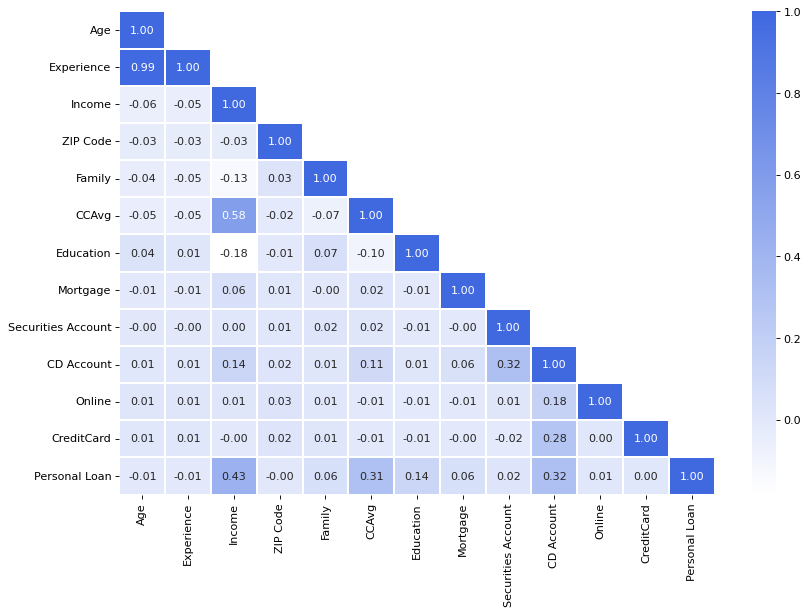

In [14]:
# Calculation of the Spearman correlation
target = 'Personal Loan'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* __Personal Loan__ is highly correlated with __Income, CD_Account, CCAvg__.
* __Experience__ is highly correlated with __Age__. (ρ = 0.99)
* __CCAvg__ is correlated with __Income__ to a good extent. (ρ = 0.58)

<a id="import"></a>
# <p style="background-color:midnightblue; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:10px 10px; padding:15px">Step 5: Data Cleansing</p>

__Data cleansing__, also known as data cleaning, is the process of preparing and structuring raw data to be used for further analysis. It includes identifying and correcting incorrect or incomplete data, removing irrelevant data, filling in missing values, and transforming existing variables. Data cleaning is an essential step in any machine learning project because it helps improve the accuracy of a model by reducing noise and errors. Poorly cleaned data can lead to overly complex models which are difficult to interpret and have a high chance of overfitting. Furthermore, dirty data can significantly reduce the accuracy of a model; even a small amount of noise will decrease its performance drastically.

##Step 5.1: Noise treatment

__Noise treatment__ is the process by which irrelevant or noisy sections of a dataset are removed before the data can be used for analysis.

I) ZIP Code Noise Treatment

In the 3d step, we found that the __ZIP Code__ feature has a minimum value that is much smaller than the average value. Let us look at the histogram of this feature again:

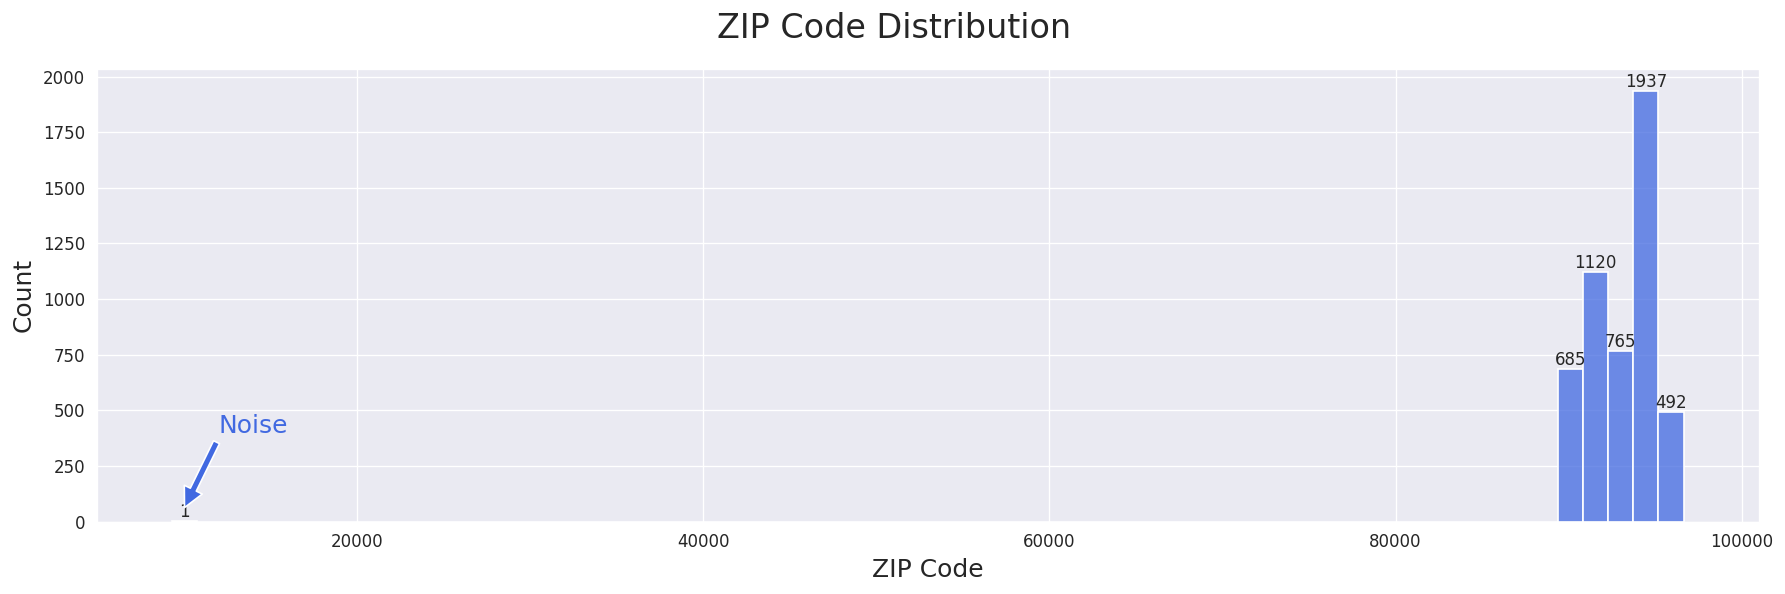

In [15]:
# Set the style of the graph
sns.set_style('darkgrid')
color = 'royalblue'

# Plot histogram
plt.figure(figsize=(15,5), dpi=120)
graph = sns.histplot(x='ZIP Code', data=df, bins=60, color=color)

# Show non-zero values of the individual bars
labels = [str(v) if v else '' for v in graph.containers[0].datavalues]
graph.bar_label(graph.containers[0], labels=labels)

plt.annotate('Noise', xy=(10000,60), xytext=(12000,400), color=color, fontsize=15, 
             arrowprops=dict(facecolor=color, shrink=0.01))
plt.xlabel('ZIP Code', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.suptitle('ZIP Code Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [16]:
df[df['ZIP Code']<20000]

Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
384   51          25      21      9307       4    0.6          3         0   

     Personal Loan  Securities Account  CD Account  Online  CreditCard  
384              0                   0           0       1           1

We found 1 noisy data in ZIP Code. We drop the corresponding sample because it contains 4 digits, while the other values of this feature all have 5 digits:

In [17]:
df.drop(df[df['ZIP Code']<20000].index, inplace=True)
df.reset_index(drop=True, inplace =True)

II) Experience Noise Treatment

As seen in the third step, the dataset contains negative values for Experience. Considering that the values of this feature indicate work experience in years, these negative values are considered noise:

In [18]:
df[df['Experience']<0]['Experience'].count()

52

Count unique negative values:

In [19]:
df[df['Experience']<0]['Experience'].value_counts()

-1    33
-2    15
-3     4
Name: Experience, dtype: int64

Since the number of these noise values in the Experience feature is small, we assume that these values are incorrectly recorded as negative and replace them with their absolute value:

In [20]:
df['Experience'] = df['Experience'].apply(abs)

##Step 5.2: Outliter treatment

__Outliers__ are data points that are significantly higher or lower than most other values in the set.

__Kurtosis__ is a measure of the "tailedness" or shape of a distribution. If the Kurtosis value is greater than 3, it is likely that the variable contains outliers. This is because excessive kurtosis indicates that the data points have a higher concentration in the tails than normal, which may indicate the presence of outliers.

In 3d step, of all the continuous features, only the __Mortgage__ feature had a kurtosis value above 3. To detect possible outliers in this feature, we use __Z-score technique__.

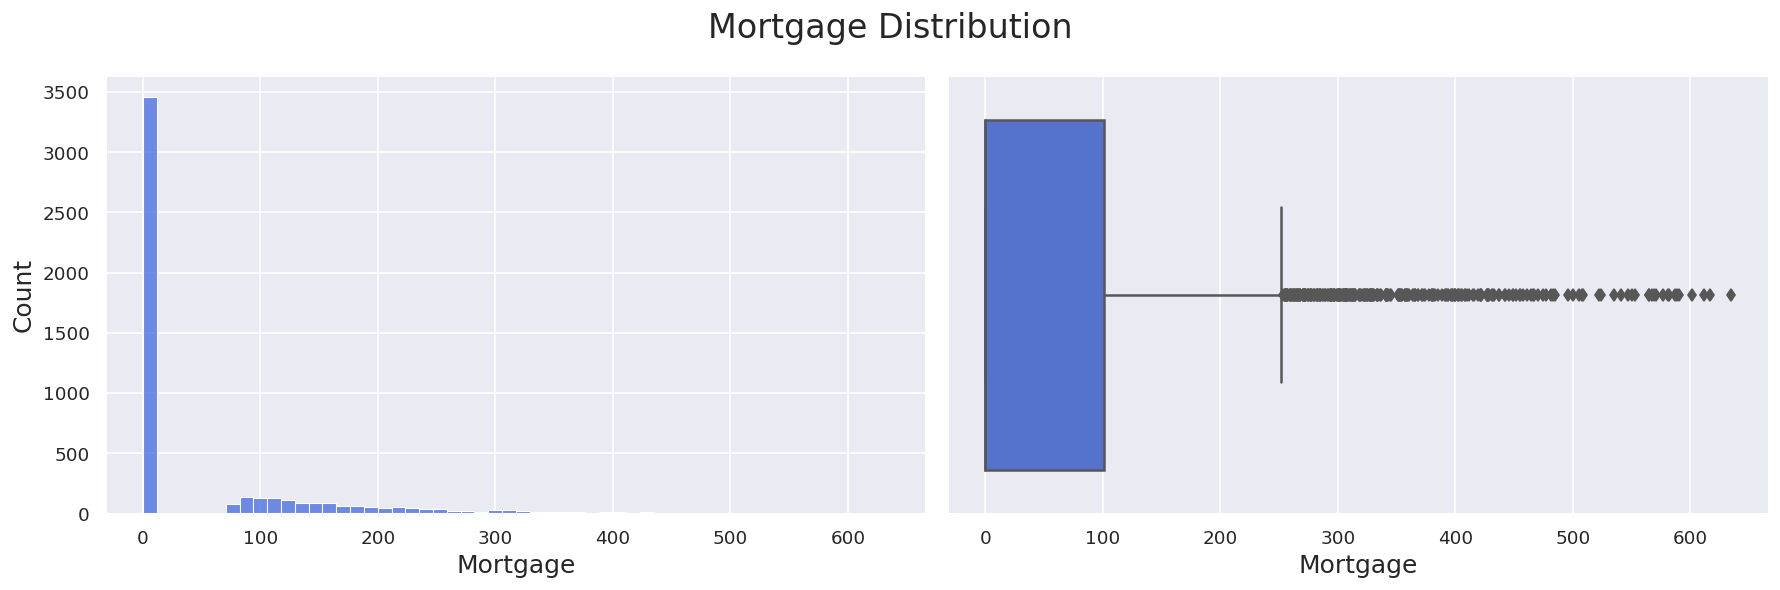

In [21]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Mortgage', data=df, color='royalblue', ax=ax[0])
sns.boxplot(x='Mortgage', data=df, color='royalblue', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

The __Z-score__ method for outlier detection is a statistical technique used to detect outliers from data sets by calculating how many standard deviations away from the mean each data point is. A data point with a Z score of more than 3 standard deviation away from the mean is considered an outlier. We use the __scipy.stats__ module to perform the zscore technique:

In [22]:
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

105

We found 105 records with a Z-score mortgage value greater than 3. Therefore, we consider these 105 records as outliers and filter out these records from our dataset:

In [23]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

##Step 5.3: Missing value treatment

In the 3rd step, we found that our dataset does not contain any __missing values__. Now let us check again if there is any missing value:

In [24]:
df.isnull().sum().sum()

0

It is clear that the dataset does not contain any missing values.

##Step 5.4: Duplicate values treatment

__Duplicate Values Treatment__ is the process of removing duplicate records from the dataset before feeding them into a machine learning algorithm. This is to ensure that only unique samples are used to train and evaluate the machine learning algorithm:

In [25]:
df[df.duplicated(keep=False)].sum().sum()

0.0

It is clear that the dataset does not contain duplicates.

##Step 5.5: Feature transformation

In the dataset, CCAVG represents average monthly credit card spending, but Income represents the amount of annual income.
To make the units of the features equal, we convert average monthly credit card spending to annual:

In [26]:
df['CCAvg'] = df['CCAvg']*12

#Step 6: Bivariate Analysis

Having considered each variable individually in univariate analysis in Step 3, we will now examine them again with respect to the __Target Variable__.

First, we will identify the relationship between the __Target Variable__ and the __Categorical Features__. Then we will look at the __Numerical Features__ compared to the __Target Variable__.

##Step 6.1: Categorical features vs target

In this part, we will create __100% stacked bar and column charts__ showing the proportion of purchased and non-purchased loans for each category of categorical features seprately:

In [27]:
# Define a list containing the names of important categorical features in the dataset 
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# Define the target name in a variable for simplicity
Target = 'Personal Loan'

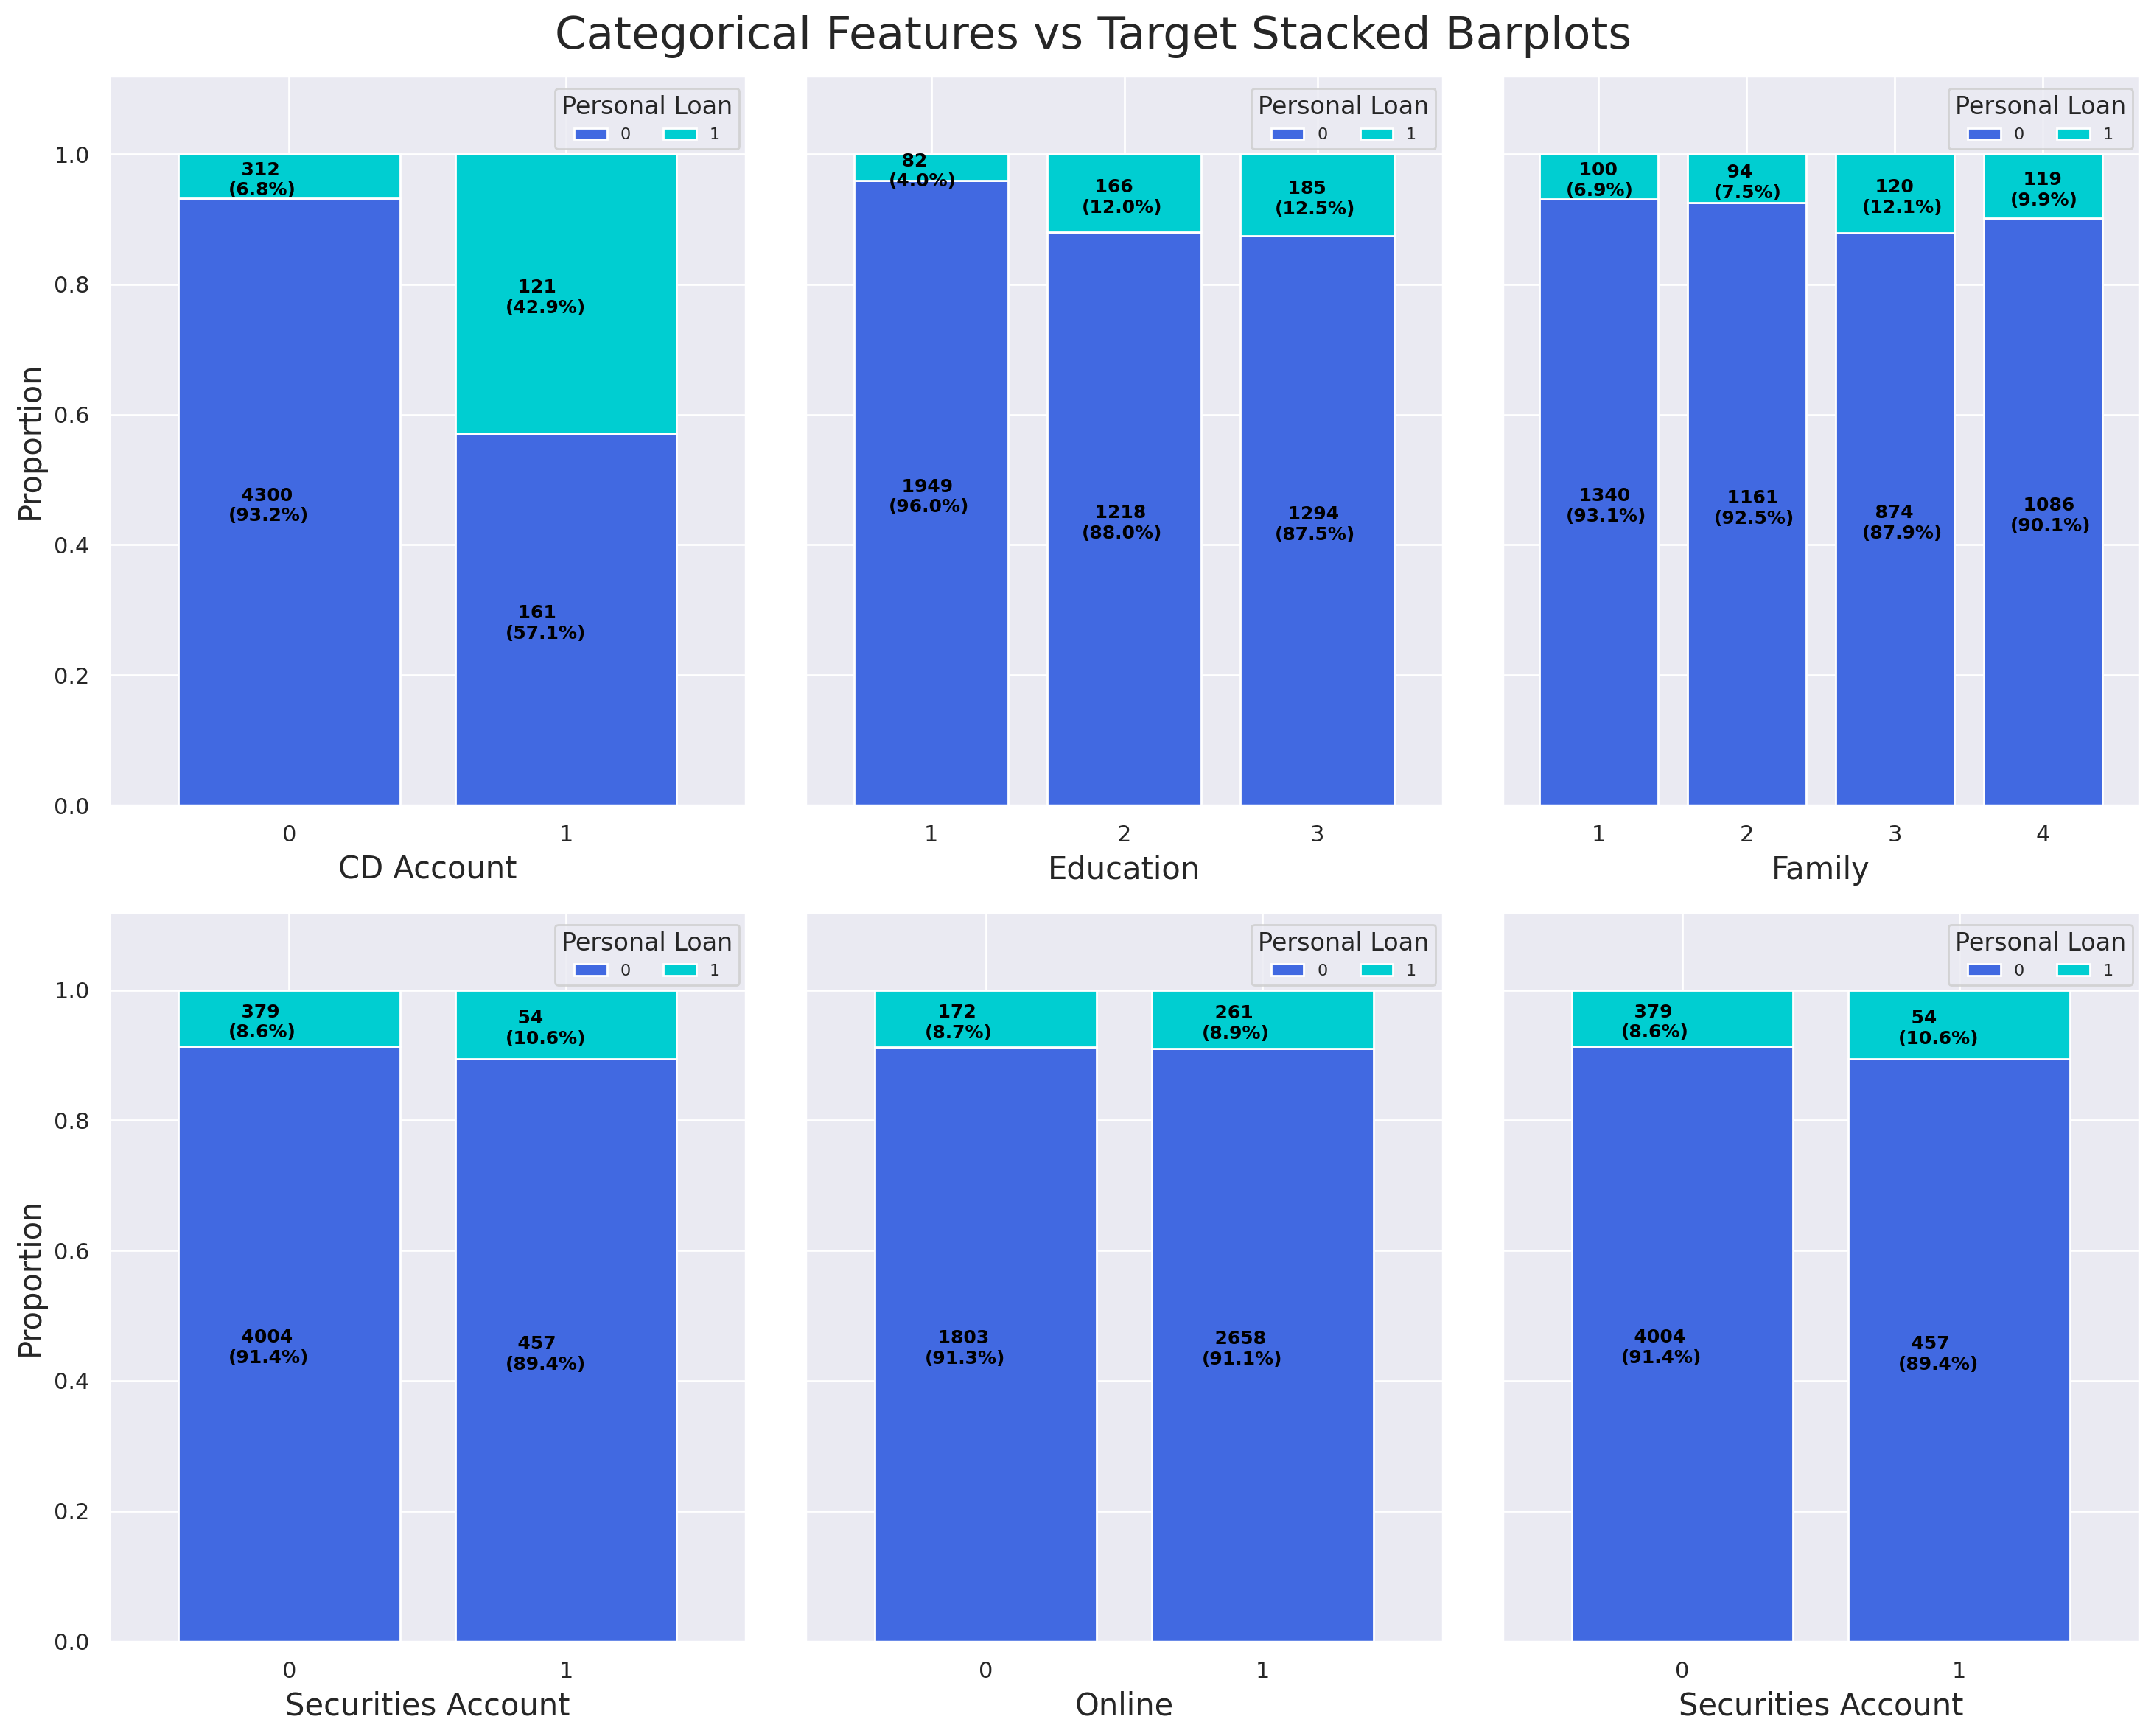

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
  
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['royalblue', 'darkturquoise'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Personal Loan', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
            

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* The customer who has a certificate of deposit (CD) with the bank appears to buy personal loans from the bank.

* Customers with higher levels of education are more likely to buy personal loans.

* The number of family members has no significant effect on the probability of buying personal loans.

* Customers who have or do not have a securities account at the bank have no influence on the probability of buying a personal loan.

* The customer who uses or does not use internet banking does not seem to have any influence on the probability of buying a personal loan.

* The customer who uses or does not use a credit card does not appear to have an impact on the likelihood of purchasing a personal loan.

##Step 6.2: Numerical features vs target

In this part, we will try to find the __mean__ and __distribution__ of numerical features for which customers purchase a personal loan versus the mean and distribution of numerical features who do not:

In [29]:
# Define a list containing the names of important numerical features in the dataset 
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

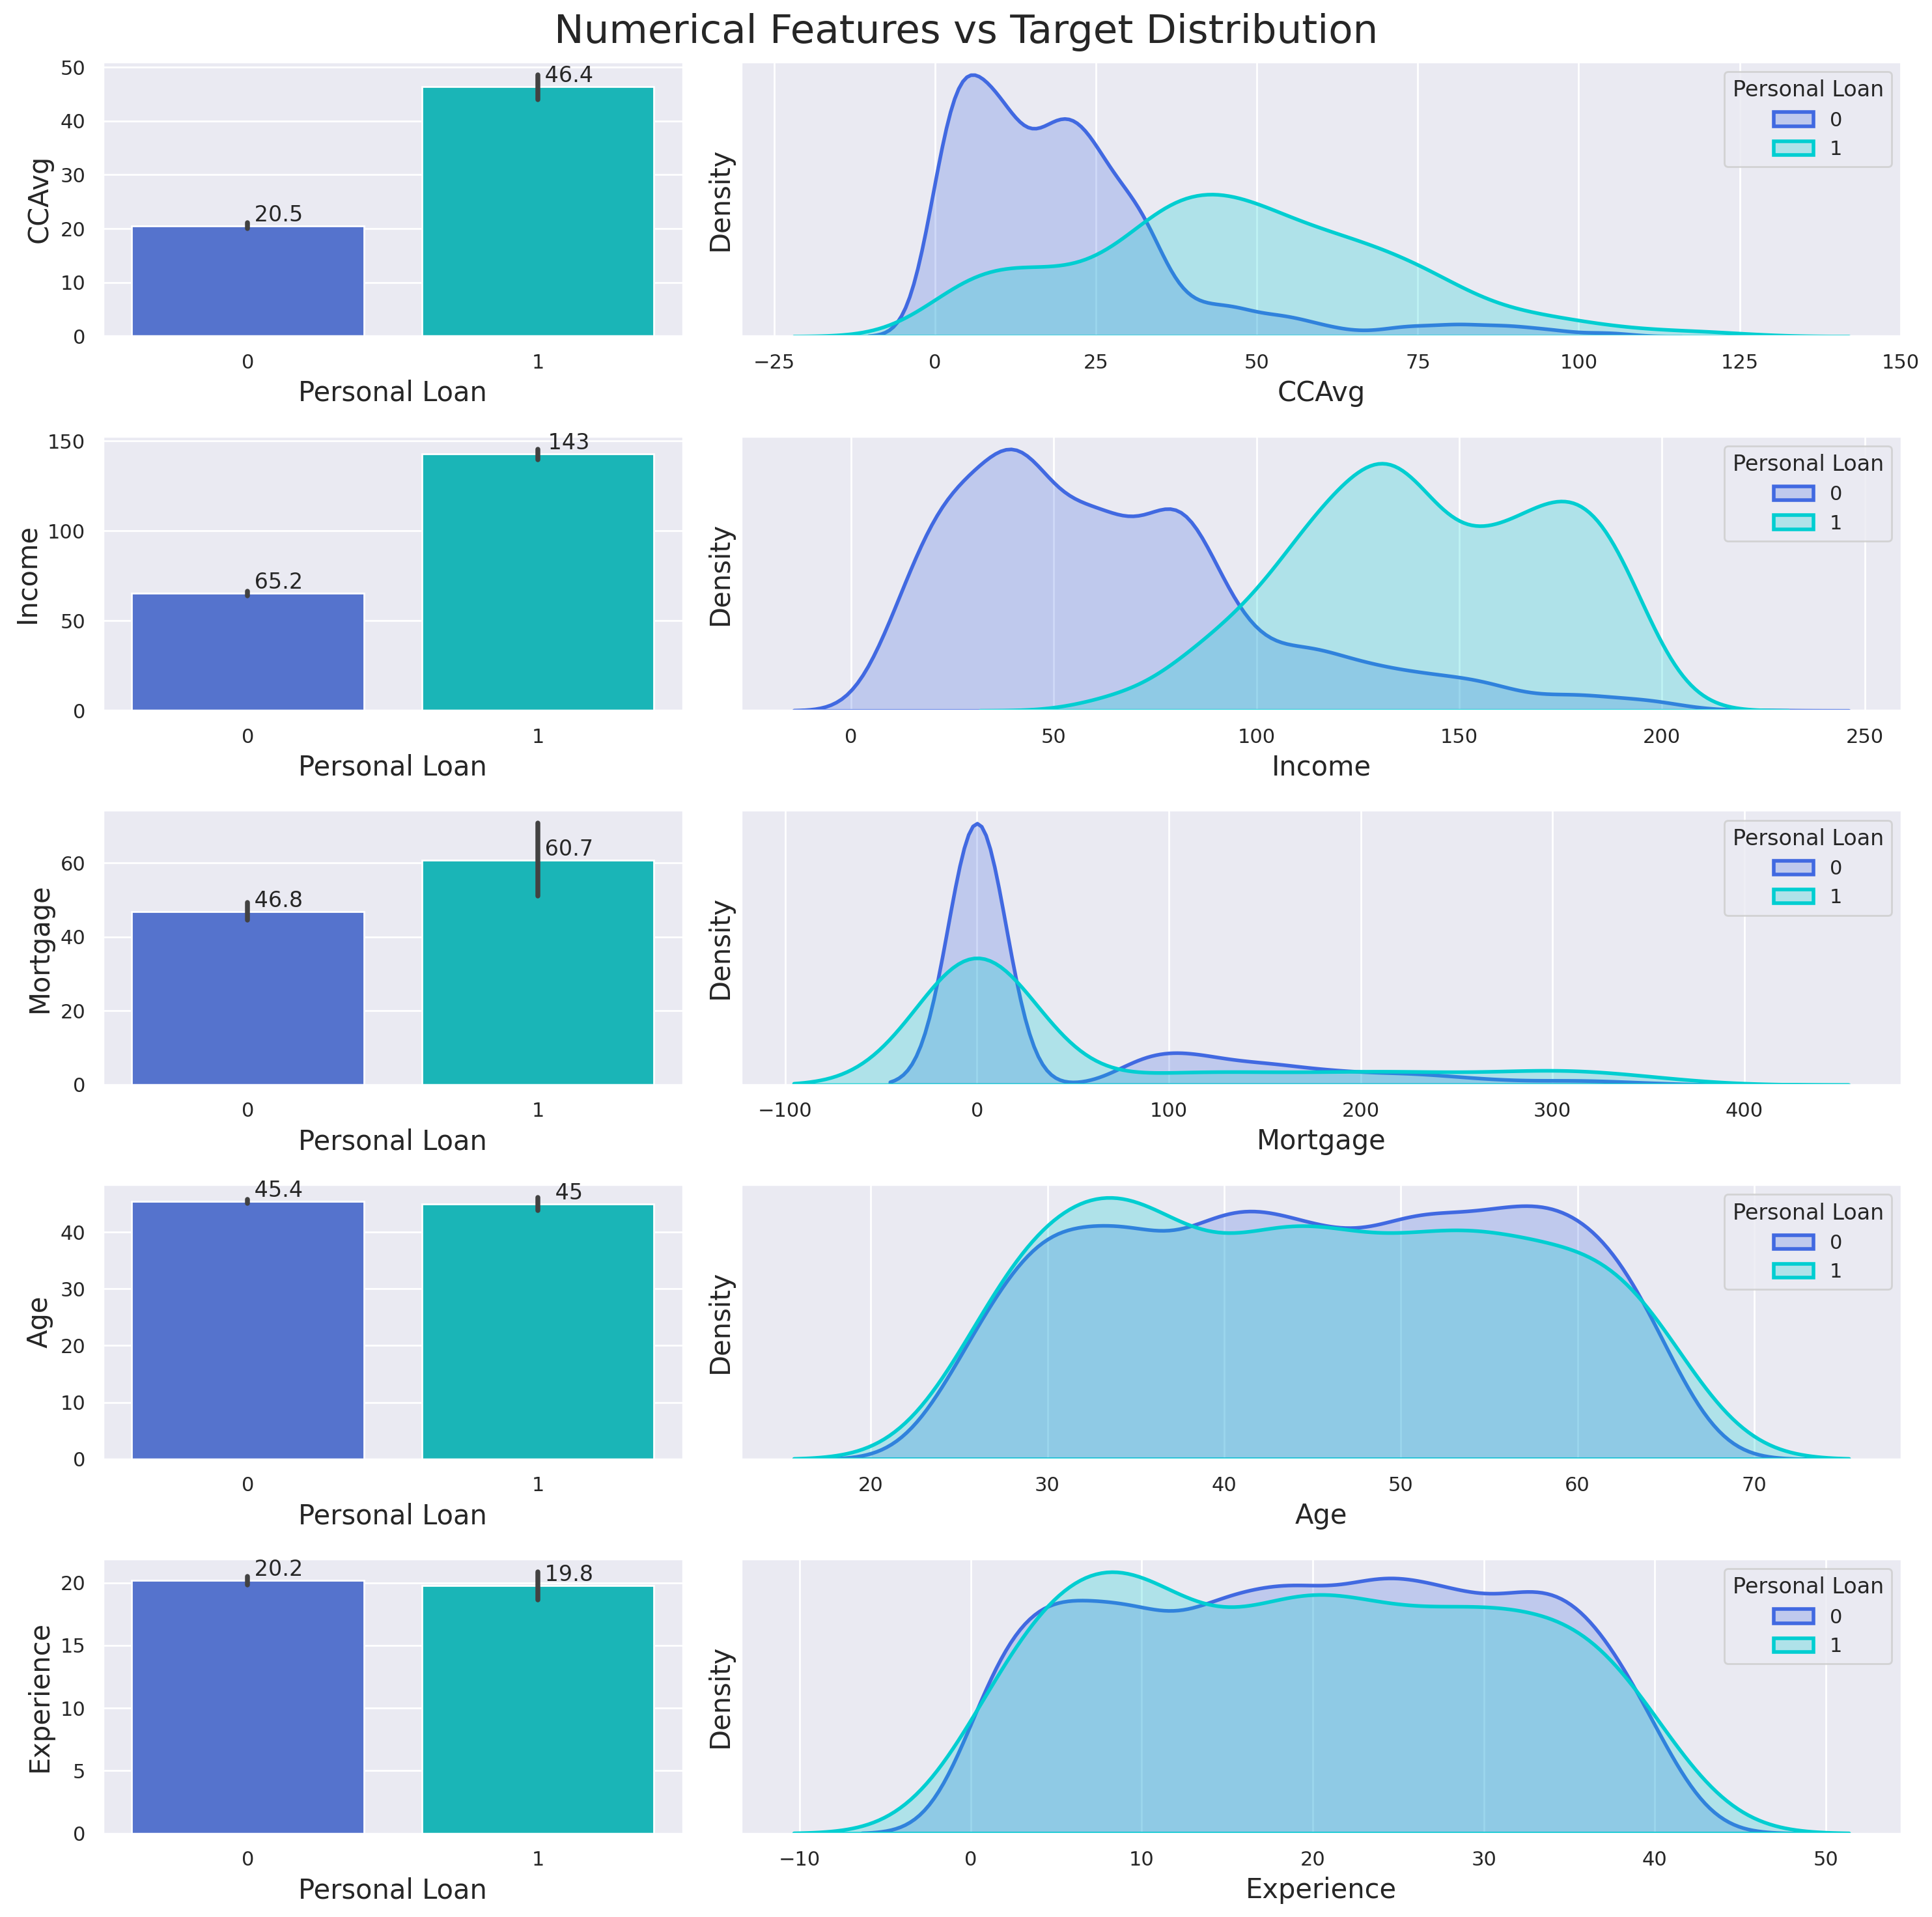

In [30]:
sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(5, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Personal Loan', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* Customers who spend more on credit cards are more likely to take out personal loans.

* Customers with high incomes are more likely to purchase a personal loan.

* Customers with a high mortgage value are more likely to purchase personal loans.

* It can be inferred that the age of customers has no influence on the probability of purchasing personal loans.

* The effect of the amount of work experience on the purchase of a loan is similar to that of the age of the customer. The distribution of the Experience is very similar to the distribution of Age, as Experience is strongly correlated with Age.

>Therefore, we remove Experience because it doesn't provide any more information than Age:

In [31]:
df.drop('Experience', axis=1, inplace=True)

#Step 7: Train Test Split

First of all, it is necessary to define the __features (X)__ and the output __labels (y)__ of the given dataset. X is a dataframe containing the different feature values for all given observations, while y is a series containing the categorical labels belonging to each observation:

In [56]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'] 

In [57]:
print(y)

0       0
1       0
2       0
3       0
4       0
       ..
4889    0
4890    0
4891    0
4892    0
4893    0
Name: Personal Loan, Length: 4894, dtype: int64


In [58]:
print(X)

      Age  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0      25      49     91107       4   19.2          1         0   
1      45      34     90089       3   18.0          1         0   
2      39      11     94720       1   12.0          1         0   
3      35     100     94112       1   32.4          2         0   
4      35      45     91330       4   12.0          2         0   
...   ...     ...       ...     ...    ...        ...       ...   
4889   29      40     92697       1   22.8          3         0   
4890   30      15     92037       4    4.8          1        85   
4891   63      24     93023       2    3.6          3         0   
4892   65      49     90034       3    6.0          2         0   
4893   28      83     92612       3    9.6          1         0   

      Securities Account  CD Account  Online  CreditCard  
0                      1           0       0           0  
1                      1           0       0           0  
2                 

We need to perform __train test split__ in supervised machine learning to evaluate the performance of a model after it has been trained. The data set is typically divided into two parts; the training set which is used to train the model, and the test set which is used to measure how well the model performs on new data. Train test split allows us to assess the generalization power of the model by checking its performance on unseen data. This technique can be used to identify any bias and variance in the model and ensure that it generalizes well on unseen examples.

____
<h2 align="left"><font color='midnightblue'>Imbalanced dataset:</font></h2>

Imbalanced dataset is a dataset where the classes are not balanced or equal. This means there are an unequal number of samples from each target class and some classes may have significantly more samples than others. 

As we saw in the 3d step, the dataset we are working on is an imbalanced dataset. Let's check it again:

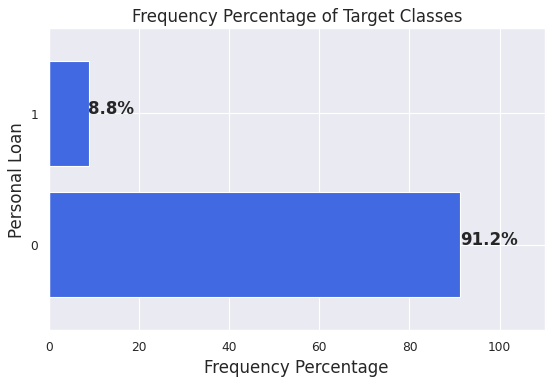

In [33]:
plt.figure(dpi=80)

# Plot frequency percentages barplot
df['Personal Loan'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = df['Personal Loan'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Personal Loan', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

As can be seen, __the dataset we are working on is imbalanced.__

____
<h2 align="left"><font color='midnightblue'>Problems with Imbalanced Datasets:</font></h2>

1. Imbalanced datasets can lead to algorithms that are biased towards the majority class. This means that any classification algorithm trained on an imbalanced dataset will often inaccurately classify minority classes as the majority class.


2. The performance of a machine learning model can become highly skewed when it is fed with imbalanced data. For example, our dataset has 91.2% class 0 and 8.8% class 1, then the learning model could be easily optimized to just predict all test input as belonging to class 0 and still get 91.2% accuracy!


3. If a model is trained on data which is heavily imbalanced, it can develop an incorrect understanding of the underlying trends in the data. The model may not be able to recognize how certain values are distributed among different classes or even how certain classes overlap with each other.

____
<h2 align="left"><font color='midnightblue'>Techniques to Handle Imbalanced Dataset:</font></h2>

<h3 align="left"><font color='royalblue'>1. The approach to train test split:</font></h3>

The approach to train test split when dealing with __imbalanced datasets__ is to use __stratification__. Stratification is an important step in splitting imbalanced datasets into training and test sets. Stratification ensures that the proportion of each class remains the same across both the training and test sets. This is important as it allows for a more accurate evaluation of the model, avoiding bias due to a disproportion of one class being over-represented in either dataset. Stratified sampling also ensures that any trends or correlations among different classes that exist within the overall dataset are preserved after splitting into training and test datasets:

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Let's see the proportion of each class across both the training and test sets:

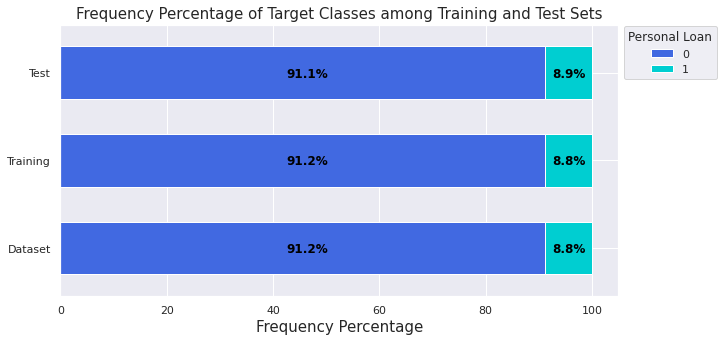

In [42]:
# Define a dataframe containing frequency percentages
df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Training','Test']
df_perc = df_perc.T

# Plot frequency percentages barplot
df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

# Add the percentages to our plot
for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Personal Loan', loc=(1.01,0.8))
plt.xlabel('Frequency Percentage', fontsize=15)
plt.title('Frequency Percentage of Target Classes among Training and Test Sets', fontsize=15)
plt.show()            

As seen, the samples are randomly divided in such a way that the proportion of each class remains the same across both the training and test sets. 

<h3 align="left"><font color='royalblue'>2. The approach for model evaluation:</font></h3>

The approach for __model evaluation__ when dealing with __imbalanced datasets__ is to use appropriate metrics including __recall, precision, F1 score and AUC(area under curve)__ that are better suited when dealing with imbalanced datasets instead of traditional accuracy metrics which don’t take into account class imbalance by default.

In this project, the main goal is to classify potential customers who are more likely to purchase a loan. The metrics used to evaluate the performance of the model will be important in determining how well the model is able to identify these potential customers.

* Recall is a measure of the proportion of actual positive cases that were correctly identified by the model. A high recall score means that the model has a low number of false negatives, which is desirable in this project because it means that the model is not missing many potential loan customers.

* Precision is a measure of the proportion of positive cases identified by the model that are actually positive. A high precision score means that the model has a low number of false positives, which is desirable in this project because it means that the model is not identifying many non-loan customers as potential loan customers.

* F1-score is a measure of the trade-off between recall and precision. It is calculated as the harmonic mean of recall and precision. A high F1-score indicates a balance between high recall and high precision.

__For this project, both recall and precision for class '1' are important metrics, so f1-score for class '1' should be considered as the most important metric. A high f1-score indicates a balance between identifying as many potential loan customers as possible (high recall) and minimizing the number of false positives (high precision). This is important for the bank, as it wants to increase the conversion rate of depositors to borrowers while reducing the cost of the marketing campaign.__